In [1]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns
import calmap

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf, expr
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

# Crime data import

In [2]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [3]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [4]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF = crimeDF.select('IncidntNum', 'Category', 'Description', 'Datetime', 'Year', 'Month', \
 'DayOfMonth', 'DayOfWeek', 'Hour', 'Minute', 'District', 'Address', 'Longitude', 'Latitude')

# Weather Data Import

In [5]:
weatherDF = spark.read.csv('s3a://davidsx/weather', header=True)

In [6]:
from pyspark.sql.functions import to_timestamp, concat_ws, regexp_replace

weatherDF = weatherDF.withColumn('Datetime_str',regexp_replace(col("DATE"), "T", " "))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'yyyy-MM-dd HH:mm:ss').cast(TimestampType()))\


weatherDF = weatherDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime"))

weatherDF = weatherDF.withColumn("Type",col("REPORT_TYPE2"))

weatherDF = weatherDF.drop('DATE','Datetime_str','REPORT_TYPE2')
# weatherDF.select('DATE').show()

In [7]:
wdDF = weatherDF.where(col('Type').like('SOD%'))
wdDF = wdDF.select(  \
 'Type',
 'Datetime',
 'Year',
 'Month',
 'DayOfMonth',
 'Hour',
 'Minute',
 'DailyAverageDryBulbTemperature',
#  'DailyCoolingDegreeDays',
#  'DailyDepartureFromNormalAverageTemperature',
#  'DailyHeatingDegreeDays',
#  'DailyMaximumDryBulbTemperature',
#  'DailyMinimumDryBulbTemperature',
 'DailyPrecipitation').where(col('Year')!=2019)
wdDF = wdDF.withColumn('Temperature_str',col('DailyAverageDryBulbTemperature')).drop('DailyAverageDryBulbTemperature')
wdDF = wdDF.withColumn('Precipitation_str',col('DailyPrecipitation')).drop('DailyPrecipitation')
# weatherDF = weatherDF.withColumn('Precipitation_str',col('Precipitation')).drop('Precipitation')
wdDF = wdDF\
.withColumn("Precipitation", when(col("Precipitation_str").endswith('s'), \
                                  expr("substring(Precipitation_str, 1, length(Precipitation_str)-1)")\
                                  .cast(DoubleType()))
            .otherwise(col("Precipitation_str").cast(DoubleType())))
wdDF = wdDF.withColumn("Temperature", col('Temperature_str').cast(DoubleType()))

# Create joined dataframe

In [8]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')
sqlContext.registerDataFrameAsTable(wdDF, 'wd')

In [9]:
joinDF = sqlContext.sql(
"select df.Category, df.Datetime, df.Year, df.Month, df.DayOfMonth, df.Hour, df.Minute, \
        df.Longitude, df.Latitude, wd.Temperature, wd.Precipitation " + 
"from df left join wd " +
"where df.Year = wd.Year and df.Month = wd.Month and df.DayOfMonth = wd.DayOfMonth")\
.where((col('Longitude').isNotNull())&(col('Latitude').isNotNull())&\
       (col('Temperature').isNotNull())&(col('Precipitation').isNotNull()))

In [10]:
count = crimeDF.groupBy('Category').count().orderBy('count')\
.filter(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES']))
total = crimeDF.filter(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES'])).count()

In [14]:
main_crime = \
[u'WARRANTS',
 u'VANDALISM',
 u'DRUG/NARCOTIC',
 u'VEHICLE THEFT',
 u'ASSAULT',
 u'LARCENY/THEFT']

# Crime vs precipitation 

In [40]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [148]:
data = joinDF.orderBy('Precipitation').groupBy('Precipitation').count()\
.where(col('Precipitation').isNotNull())\
.where(col('Precipitation').between(0.01,0.70))\

In [160]:
precipitation = data.rdd.map(lambda x: round(x[0],2)).collect()
precipitation = list(precipitation)
xlen = len(precipitation)
ylen = 1
count = data.rdd.map(lambda x:x[1]).collect()
clen = len(count)
data2d = data.collect()

In [161]:
img_p = np.zeros(xlen, dtype=float).reshape(1,xlen)
#calculation of index between 0 and 1
maxc = np.amax(count)
minc = np.amin(count)
flow = maxc - minc

for row in data2d:
    prep = row[0]
    value = row[1]
    img_p[0][precipitation.index(prep)] = value/float(maxc)
    
# for row in img_p:
#     row[i] = (value-minc)/maxc

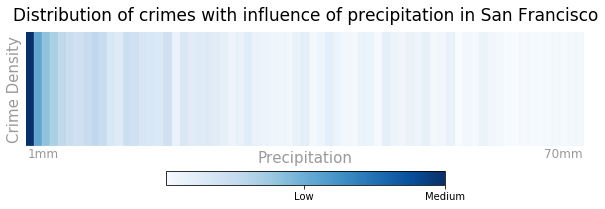

In [162]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(10,3),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=0.2)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_p,  aspect='auto', cmap=cm.Blues)

# plt.text(-15, 0, 'Crime Density', color='#999999',  size='15')
plt.text(-.30, .6, '1mm', color='#999999', size='12')
plt.text(xlen-5.5, .6, '70mm', color='#999999', size='12')
# y-axis labels
plt.title("Distribution of crimes with influence of precipitation in San Francisco", size=17, y=1.05)
plt.xlabel("Precipitation", color='#999999', size="15")
plt.ylabel("Crime Density", color='#999999', size="15")

ax.yaxis.set_label_position("left")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.5, orientation='horizontal')
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])

plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

plt.show()

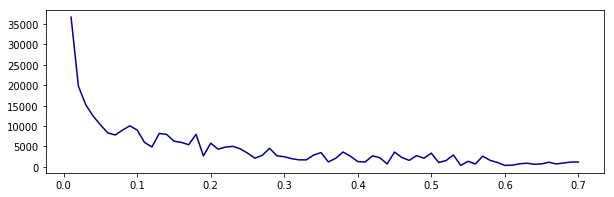

In [164]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)

ax.plot(precipitation,count, color='darkblue')

# Crime vs temperature 

In [166]:
data_t = joinDF.orderBy('Temperature').groupBy('Temperature').count()\
.where(col('Temperature').isNotNull())\

In [167]:
temperature = data_t.orderBy('Temperature').groupBy('Temperature').count().rdd.map(lambda x: x[0]).collect()
temperature = list(temperature)
xlen = len(temperature)

In [176]:
ylen = 1
count = data_t.rdd.map(lambda x:x[1]).collect()
count = list(count)
clen = len(count)
data2d = data_t.collect()

In [169]:
img_t = np.zeros(ylen*xlen, dtype=float).reshape(ylen,xlen)
#calculation of index between 0 and 1
maxc = np.amax(count)
minc = np.amin(count)
flow = maxc - minc

for row in data2d:
    temp = row[0]
    value = row[1]
    img_t[0][temperature.index(temp)] = value/float(maxc)

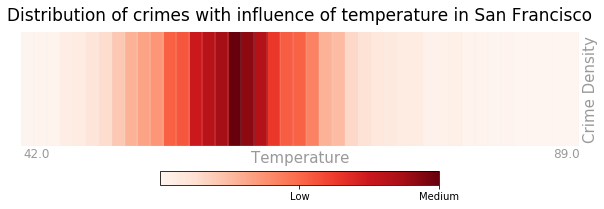

In [170]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(10,3),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=0.2)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_t,  aspect='auto', cmap=cm.Reds)

plt.text(-.30, .6, str(temperature[0]), color='#999999', size='12')
plt.text(xlen-2.5, .6, str(temperature[-1]), color='#999999', size='12')

# title, xlabel, ylabel
plt.title("Distribution of crimes with influence of temperature in San Francisco", size=17, y=1.05)
plt.xlabel("Temperature", color='#999999', size="15")
plt.ylabel("Crime Density", color='#999999', size="15")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.5, orientation='horizontal')
cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])

plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

plt.show()

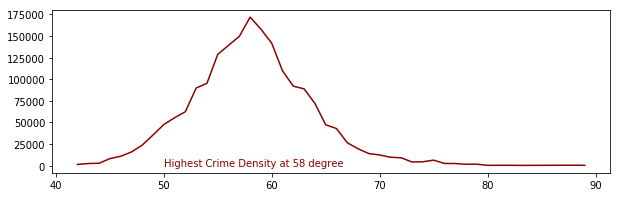

In [202]:
tmax = np.amax(count)
tval = temperature[count.index(tmax)]

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
plt.text(50,70,"Highest Crime Density at {0:.0f} degree".format(tval),color='darkRed')
ax.plot(temperature,count, color='darkred')

In [10]:
categories = [u'ARSON', u'ASSAULT', u'BAD CHECKS', u'BRIBERY', u'BURGLARY', u'DISORDERLY CONDUCT',\
              u'DRIVING UNDER THE INFLUENCE', u'DRUG/NARCOTIC', u'DRUNKENNESS', u'EMBEZZLEMENT', \
              u'EXTORTION', u'FAMILY OFFENSES', u'FORGERY/COUNTERFEITING', u'FRAUD', u'GAMBLING', \
              u'KIDNAPPING', u'LARCENY/THEFT', u'LIQUOR LAWS', u'LOITERING', u'MISSING PERSON', \
              u'NON-CRIMINAL', u'OTHER OFFENSES', u'PORNOGRAPHY/OBSCENE MAT', u'PROSTITUTION', \
              u'RECOVERED VEHICLE', u'ROBBERY', u'RUNAWAY', u'SECONDARY CODES', \
              u'SEX OFFENSES, FORCIBLE', u'SEX OFFENSES, NON FORCIBLE', u'STOLEN PROPERTY', \
              u'SUICIDE', u'SUSPICIOUS OCC', u'TREA', u'TRESPASS', u'VANDALISM', u'VEHICLE THEFT',\
              u'WARRANTS', u'WEAPON LAWS']

In [1]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

data = joinDF.groupBy('Category','Temperature').count().orderBy('Category','Temperature')
x = data.rdd.map(lambda x: x[1]).collect()
y = data.rdd.map(lambda x: x[2]).collect()
ax.plot(x,y, color='darkred')

for cat in categories:
    data = joinDF.where(col('Category')==cat).groupBy('Temperature').count().orderBy('Temperature')
    x = data.rdd.map(lambda x: x[0]).collect()
    y = data.rdd.map(lambda x: x[1]).collect()
    ax.plot(x,y, color='grey')

NameError: name 'plt' is not defined

In [313]:
joinDF.orderBy('Year').groupBy('Year').avg('Temperature').show()
temp = joinDF.orderBy('Year').groupBy('Year').avg('Temperature')
x = temp_count.rdd.map(lambda x: x[0]).collect()
y = temp_count.rdd.map(lambda x: x[1]).collect()

+----+------------------+
|Year|  avg(Temperature)|
+----+------------------+
|2005| 58.34817109584951|
|2006| 57.07521109595798|
|2007| 57.65188645660024|
|2008| 57.74488893292101|
|2009|57.865564604351526|
|2010| 57.26009751129019|
|2011|57.043870060554745|
|2012|57.190372395186195|
|2013|57.871313953640566|
|2014|60.263115474794844|
|2015| 60.11763540881387|
|2016| 58.71374508725304|
|2017|  59.0994617924315|
|2018| 55.55216565185473|
+----+------------------+



In [144]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection, QuadMesh
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain

import fiona

shp = fiona.open('sffind_neighborhoods.shp')

# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
#left bottom
# ll = (bds[0], bds[1])
#right top
# ur = (bds[2], bds[3])
# coords = list(chain(ll, ur))
coords = list(bds)
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

Read SF neighborhood data into Basemap


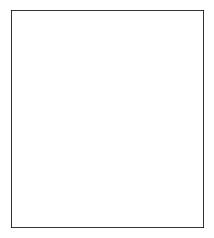

In [105]:
m = Basemap(
    projection='tmerc',
    lon_0=coords[0]+w/2,
    lat_0=coords[1]+h/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'sffind_neighborhoods',
    'SF',
    color='none')

print "Read SF neighborhood data into Basemap"

In [141]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 1000000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=1))
# df_map.ward_name.count()

<Figure size 432x288 with 0 Axes>

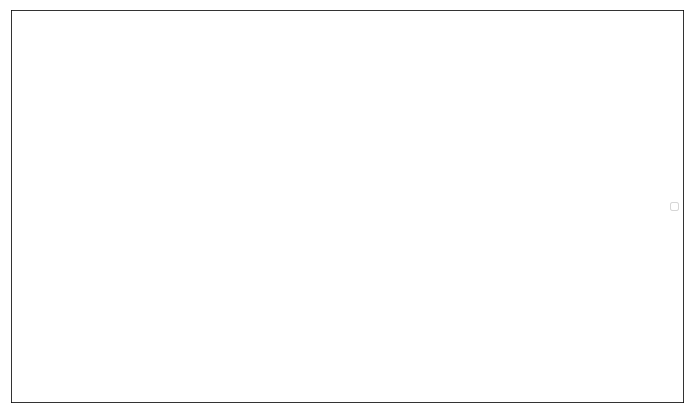

In [165]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

ax.axis([x.min(), x.max(), y.min(), y.max()])
# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(coords[0], coords[2], 100), np.linspace(coords[1], coords[3], 100))

z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

# bmScatter(2)
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, zorder=2)
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# m.drawmapscale(
#     coords[0] + 0.015, coords[1] - 0.005,
#     coords[0], coords[1],
#     2.,
#     barstyle='fancy', labelstyle='simple',
#     fillcolor1='w', fillcolor2='#555555',
#     fontcolor='#555555')

m.pcolormesh(x,y,z,shading='flat',cmap='RdBu',latlon=False,zorder=5)

# fig.colorbar(c, ax=ax)
plt.tight_layout()
plt.legend(loc="center right")
# plt.title("Geographic distribution of crimes in San Francisco during Summer {}".format(pts_label[2]), size=17)
fig.set_size_inches(10,10)
plt.show()

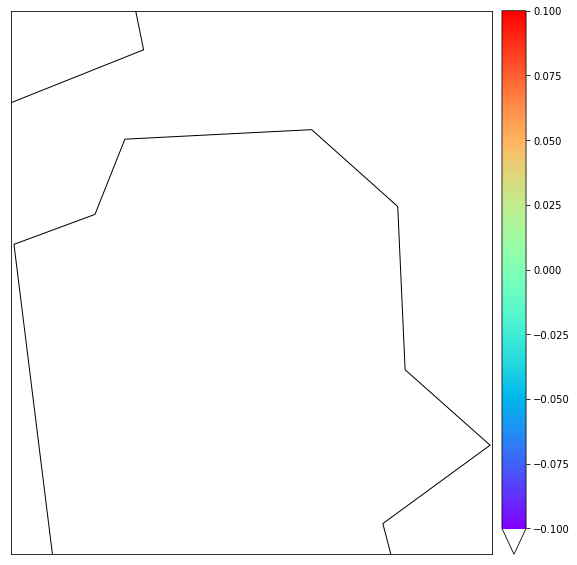

In [157]:
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pandas import DataFrame

fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

# m = Basemap(llcrnrlon = -170, llcrnrlat = 10, urcrnrlon = -50, urcrnrlat = 80)
m = Basemap(
    projection='tmerc',
    lon_0=coords[0]+w/2,
    lat_0=coords[1]+h/2,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.drawcoastlines()
m.drawstates()

# ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
# lon = np.array([-95,  -94,  -93,  -92, -91])
# lat = np.array([43, 42, 41])
# data = np.array([[0,4,8,3],[7,3,0,0]])
# you have to write just like here to convert coordinates
# x,y = m(lon,lat)
x, y = np.meshgrid(np.linspace(coords[0], coords[2], 100), np.linspace(coords[1], coords[3], 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()

my_cmap = plt.get_cmap('rainbow')
my_cmap.set_under('white')
cs = m.pcolormesh(x,y,z,cmap = my_cmap)
m.colorbar(cs, extend = 'min')
fig.set_size_inches(15,10)
plt.show()

In [ ]:
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pandas import DataFrame

m = Basemap(llcrnrlon = -170, llcrnrlat = 10, urcrnrlon = -50, urcrnrlat = 80)
m.drawcoastlines()
m.drawstates()

lon = np.array([-95,  -94,  -93,  -92, -91])
lat = np.array([43, 42, 41])
data = np.array([[0,4,8,3],[7,3,0,0]])
# you have to write just like here to convert coordinates
x,y = m(lon,lat)

my_cmap = plt.get_cmap('rainbow')
my_cmap.set_under('white')
cs = m.pcolormesh(x,y,data,cmap = my_cmap)
m.colorbar(cs, extend = 'min')
plt.show()